# Data Wrangling

Some data needs to be downloaded manually yourself before you can run the commands below.

## LitPop's population count data

Gridded Population of the World (GPW), v4: Population Count, v4.10, v4.11 or later versions (2000, 2005, 2010, 2015, 2020), available from http://sedac.ciesin.columbia.edu/data/collection/gpw-v4/sets/browse.

The GPW file of the year closest to the requested year (reference_year) is required. To download GPW data a (free) login for the NASA SEDAC website is required.

Direct download links are avilable, also for older versions, i.e.:

    v4.11: http://sedac.ciesin.columbia.edu/downloads/data/gpw-v4/gpw-v4-population-count-rev11/gpw-v4-population-count-rev11_2015_30_sec_tif.zip
    v4.10: http://sedac.ciesin.columbia.edu/downloads/data/gpw-v4/gpw-v4-population-count-rev10/gpw-v4-population-count-rev10_2015_30_sec_tif.zip,
    Overview over all versions of GPW v.4: https://beta.sedac.ciesin.columbia.edu/data/collection/gpw-v4/sets/browse

The population data from GWP needs to be downloaded manually as TIFF from this site and placed in the SYSTEM_DIR folder of your climada installation.

## Landslide data

For landslide data, you need to download the data from Cooperative Open Online Landslide Repository (https://pmm.nasa.gov/landslides/coolrdata.html#download)

The most recent version of the dataset should always be downloaded by going to the link > “Open Landslide Viewer” (takes some time to load) > click “Download the full Landslide Catalog” > selecting the “NASA Global Landslide Catalog Points (Shapefile)” for download.

Unzip and extract into the /climada folder in your home directory (not the climada-python or climada-petals code repositories).

Important: The original file has a typo in one of its entries, which messes up the reading of a bounding box. Reading it once into memory with geopandas and re-saving it as shapefile solves this. This has to be done only once.

In [27]:
# Amending the Landslide catalog by loading and re-saving (only necessary first time!)
import geopandas as gpd
from climada import CONFIG

# replace with your path to file nasa_global_landslide_catalog_point.shp if not in ~/climada/data folder
PATH_COOLR = str(CONFIG.local_data.system.dir()) + '/nasa_global_landslide_catalog_point/nasa_global_landslide_catalog_point.shp'
ls_gdf_all = gpd.read_file(PATH_COOLR)
ls_gdf_all.to_file(PATH_COOLR)

# Computation

An impact calculation combines a given Hazard with Exposure and Impact functions to output an Impact. The Impact class can be used to output data as needed. The calculation uses the nearest neighbor Exposure for a given Hazard Centroid. It's recommended to set the spatial resolution by the initialization of the Exposure, and then matching the centroids to the grid in Exposure, for a 1 to 1 calculation.

Exposure is independent of hazard, but the impact functions are for associated hazards. If you want to output a certain impact, say of cyclones, floods, drought, you need to create the Hazard class, specify the hazard data, and ensure there are meaningful impact functions for that hazard.

In [23]:
%matplotlib inline
import numpy as np

## Exposure

Set up exposure using LitPop. Default parameters are resolution of 30 arcsec, produced capital ('pc') as total asset value, and exponents of (lit, pop) as (1,1). These can be changed when calling `LitPop`.
For NZ, seems there is no pc data, and 'non-financial wealth' was by default used as total asset value. 

In [24]:
from climada.entity import LitPop

In [28]:
# NZ with resolution 10km
exp_lp = LitPop.from_countries(countries=['NZL'], res_arcsec=300)
exp_lp.check()

2024-07-12 12:01:19,902 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-12 12:01:19,927 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-12 12:01:19,945 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-12 12:01:19,962 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-12 12:01:19,995 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-12 12:01:20,012 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-12 12:01:20,031 - climada.entity.exposures.litpop.gpw_populati


 Raster properties exposures: {'width': 4268, 'height': 218, 'crs': <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, 'transform': Affine(0.08333332999998788, 0.0, -176.83333333500002,
       0.0, -0.08333333000000209, -34.416666665)}


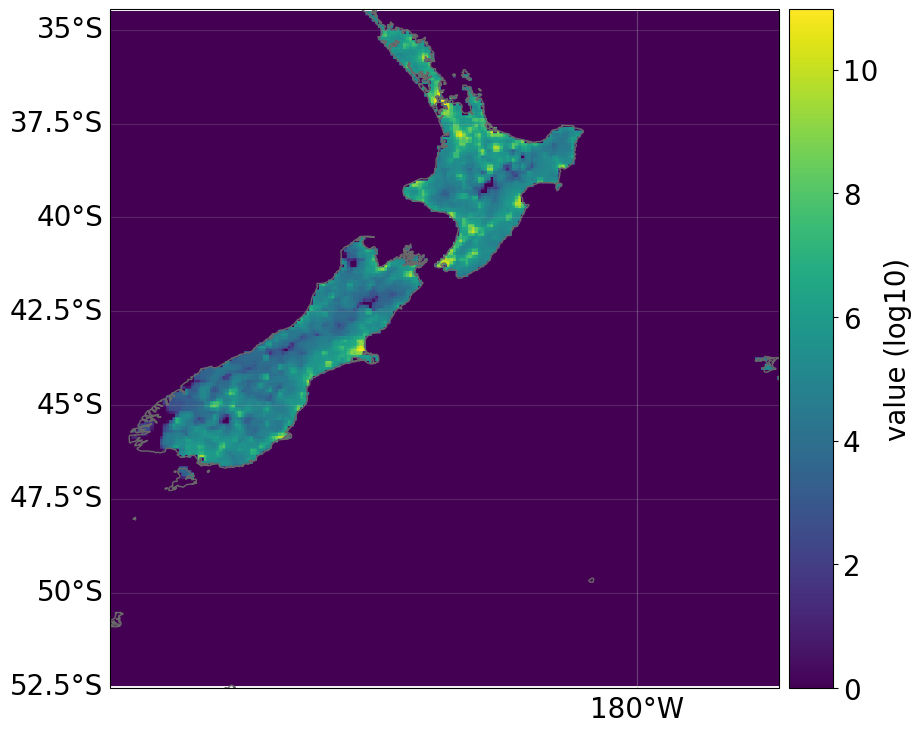

In [29]:
# not needed for impact calculations
# visualize the define exposure
exp_lp.plot_raster()
print('\n Raster properties exposures:', exp_lp.meta)

## Hazard

### Cyclones

In [8]:
from climada.hazard import TCTracks, TropCyclone, Centroids

# Load histrocial tropical cyclone tracks from ibtracs over the North Atlantic basin between 2010-2012
ibtracks_nz = TCTracks.from_ibtracs_netcdf(provider='wellington', basin='SP', year_range=(2010, 2012), correct_pres=True)
print('num tracks hist:', ibtracks_nz.size)

ibtracks_nz.equal_timestep(0.5)  # Interpolation to make the track smooth and to allow applying calc_perturbed_trajectories
# Add randomly generated tracks using the calc_perturbed_trajectories method (1 per historical track)
ibtracks_nz.calc_perturbed_trajectories(nb_synth_tracks=1)
print('num tracks hist+syn:', ibtracks_nz.size)

2024-07-12 10:42:49,470 - climada.hazard.tc_tracks - WARNING - `correct_pres` is deprecated. Use `estimate_missing` instead.
2024-07-12 10:42:49,661 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/ming/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-07-12 10:42:50,423 - climada.hazard.tc_tracks - WARNING - 13 storm events are discarded because no valid wind/pressure values have been found: 2010020S14147, 2010022S12160, 2010027S14184, 2010038S08194, 2010051S06195, ...
num tracks hist: 30
num tracks hist+syn: 30


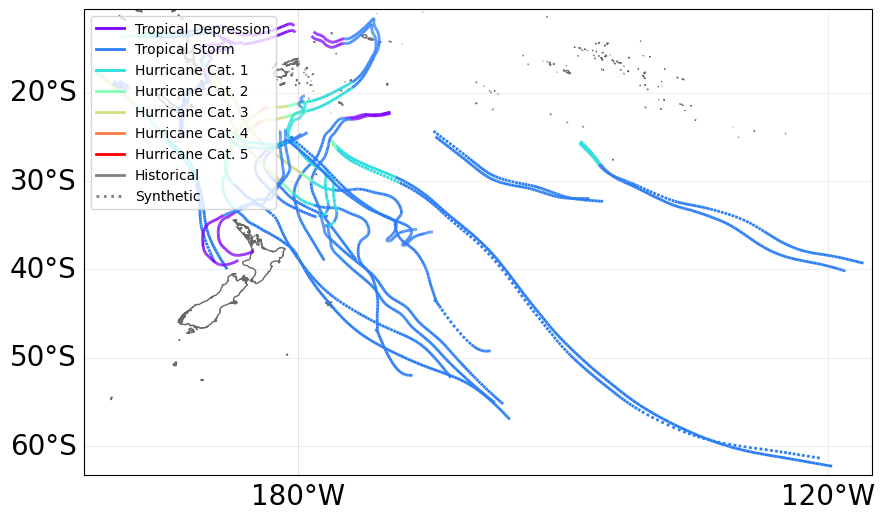

In [9]:
# not needed for calculations
# visualize tracks
ax = ibtracks_nz.plot()
ax.get_legend()._loc = 2

In [7]:
# Define the centroids from the exposures position
lat = exp_lp.gdf['latitude'].values
lon = exp_lp.gdf['longitude'].values
centrs = Centroids.from_lat_lon(lat, lon)
centrs.check()

In [10]:
# Using the tracks, compute the windspeed at the location of the centroids
tc = TropCyclone.from_tracks(ibtracks_nz, centroids=centrs)
tc.check()

In [11]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone
# impact function TC
impf_tc = ImpfTropCyclone.from_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet([impf_tc])
impf_set.check()

In [12]:
# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

hazard type: TC, hazard id: 1


In [13]:
# Exposures: rename column and assign id
exp_lp.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
exp_lp.gdf['impf_' + haz_type] = haz_id
exp_lp.check()
exp_lp.gdf.head()

,value,latitude,longitude,geometry,region_id,impf_TC
0,0.0,-50.875000,165.958333,POINT (165.95833 -50.87500),554,1
1,0.0,-50.875000,166.041667,POINT (166.04167 -50.87500),554,1
2,0.0,-50.875000,166.125000,POINT (166.12500 -50.87500),554,1
3,0.0,-50.541667,166.125000,POINT (166.12500 -50.54167),554,1
4,0.0,-50.541667,166.208333,POINT (166.20833 -50.54167),554,1


In [14]:
# Compute impact
from climada.engine import ImpactCalc
imp = ImpactCalc(exp_lp, impf_set, tc).impact(save_mat=False)  # Do not save the results geographically resolved (only aggregate values)


In [15]:
exp_lp.gdf

,value,latitude,longitude,geometry,region_id,impf_TC,centr_TC
0,0.000000e+00,-50.875000,165.958333,POINT (165.95833 -50.87500),554,1,0
1,0.000000e+00,-50.875000,166.041667,POINT (166.04167 -50.87500),554,1,1
2,0.000000e+00,-50.875000,166.125000,POINT (166.12500 -50.87500),554,1,2
3,0.000000e+00,-50.541667,166.125000,POINT (166.12500 -50.54167),554,1,3
4,0.000000e+00,-50.541667,166.208333,POINT (166.20833 -50.54167),554,1,4
...,...,...,...,...,...,...,...
4194,3.537527e+06,-36.791667,175.125000,POINT (175.12500 -36.79167),554,1,4194
4195,2.371736e+05,-36.208333,175.375000,POINT (175.37500 -36.20833),554,1,4195
4196,5.130039e+05,-36.208333,175.458333,POINT (175.45833 -36.20833),554,1,4196
4197,5.367681e+05,-36.291667,175.541667,POINT (175.54167 -36.29167),554,1,4197


In [16]:
print(f"Aggregated average annual impact: {round(imp.aai_agg,0)} $")

Aggregated average annual impact: 0.0 $


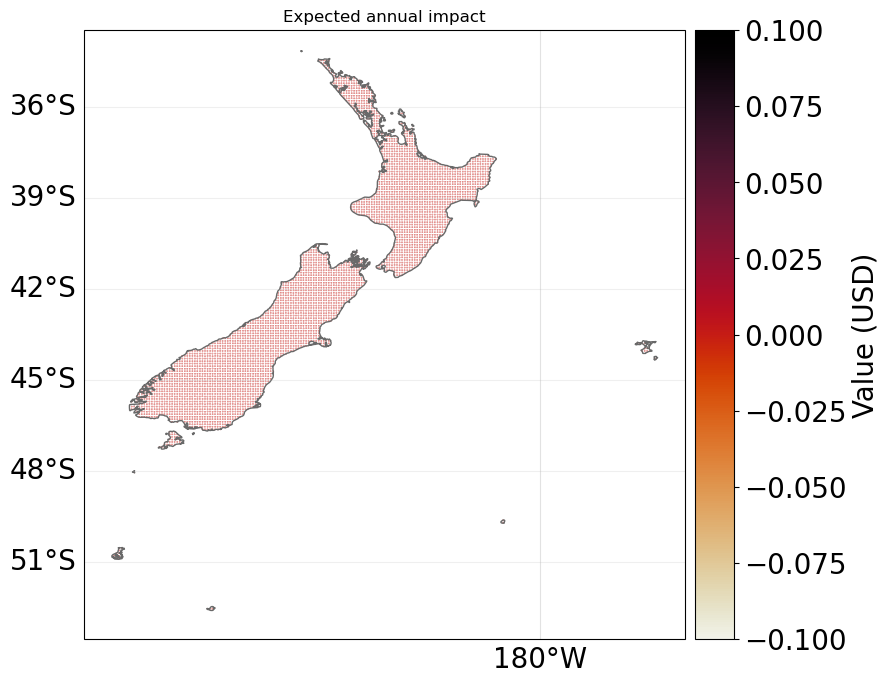

In [17]:
imp.plot_hexbin_eai_exposure(buffer=1);

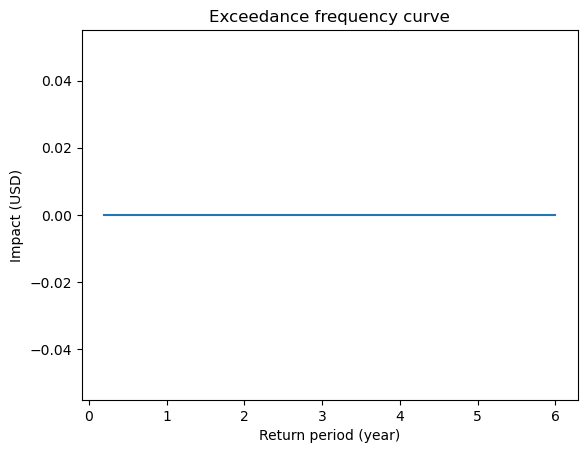

In [18]:
# Compute exceedance frequency curve
freq_curve = imp.calc_freq_curve()
freq_curve.plot();

### Landslide

In [30]:
from climada_petals.hazard.landslide import Landslide
from climada import CONFIG
# replace with your path to file nasa_global_landslide_catalog_point.shp if not in ~/climada/data folder
PATH_COOLR = str(CONFIG.local_data.system.dir()) + '/nasa_global_landslide_catalog_point/nasa_global_landslide_catalog_point.shp'
